In [1]:
## Main libraries import;
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from glob import glob
from PIL import Image

np.random.seed(50)

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


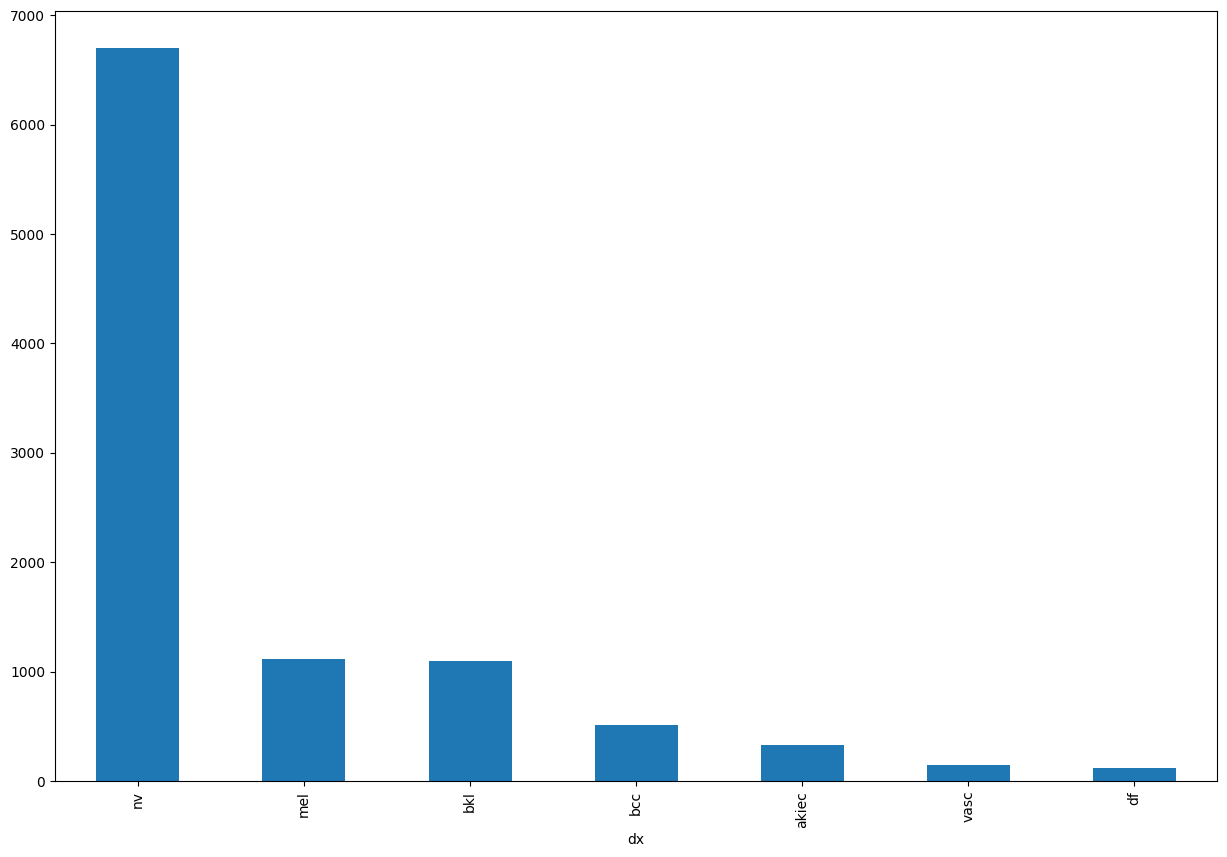

In [2]:
## Loading Data into data frame ;
dataframe = pd.read_csv("Data\\HAM10000\\HAM10000_metadata.csv")

## Image loading ;
# --> Dictionnary : Image name without extension - its path
img_path = {os.path.splitext(os.path.basename(x))[0] : x for x in glob("Data\\HAM10000\\HAM10000_images\\*.jpg")}

## New path column in the dataframe ;
dataframe["path"] = dataframe["image_id"].map(img_path.get)

## New image column in the dataframe ;
# --> Each image is converted into a numpy array (its RGB values)
size = (32,32)
dataframe["image"] = dataframe["path"].map(lambda x : np.asarray(Image.open(x).resize(size)))

## Printing each Image class count (7 classes) ;
print(dataframe["dx"].value_counts())

## Data imbalance visualization ;
figure = plt.figure(figsize=(15,10))
dataframe["dx"].value_counts().plot(kind="bar")
plt.show()

In [3]:
## ===> Conclusion : Very Imbalanced Data

## ML libraries import (keras - scikitlearn - scipy);
import keras

# Labels into one-hot-encoding
from keras.utils import to_categorical

# Model loading. saving and image testing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


from keras.models import Sequential
from keras.layers import Dropout, MaxPool2D, Conv2D, BatchNormalization, Dense, Flatten
from sklearn.model_selection import train_test_split

# For encoding the 7 class labels
from sklearn.preprocessing import LabelEncoder 
# Class distribution
from sklearn.utils import resample


In [4]:
## Encoding classes ;
labels = LabelEncoder()
labels.fit(dataframe["dx"])
LabelEncoder()

## New Dataframe column with labels ;
dataframe["label"] = labels.transform(dataframe["dx"])

## Printing each Image class count by label (7 classes) ;
print(dataframe["label"].value_counts())

## Label dictionnary :
label_to_class = {
    0 : "akiec",
    1 : "bcc",
    2 : "bkl",
    3 : "df",
    4 : "mel",
    5 : "nv",
    6 : "vasc"
}

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


label
0    850
1    850
2    850
3    850
4    850
5    850
6    850
Name: count, dtype: int64


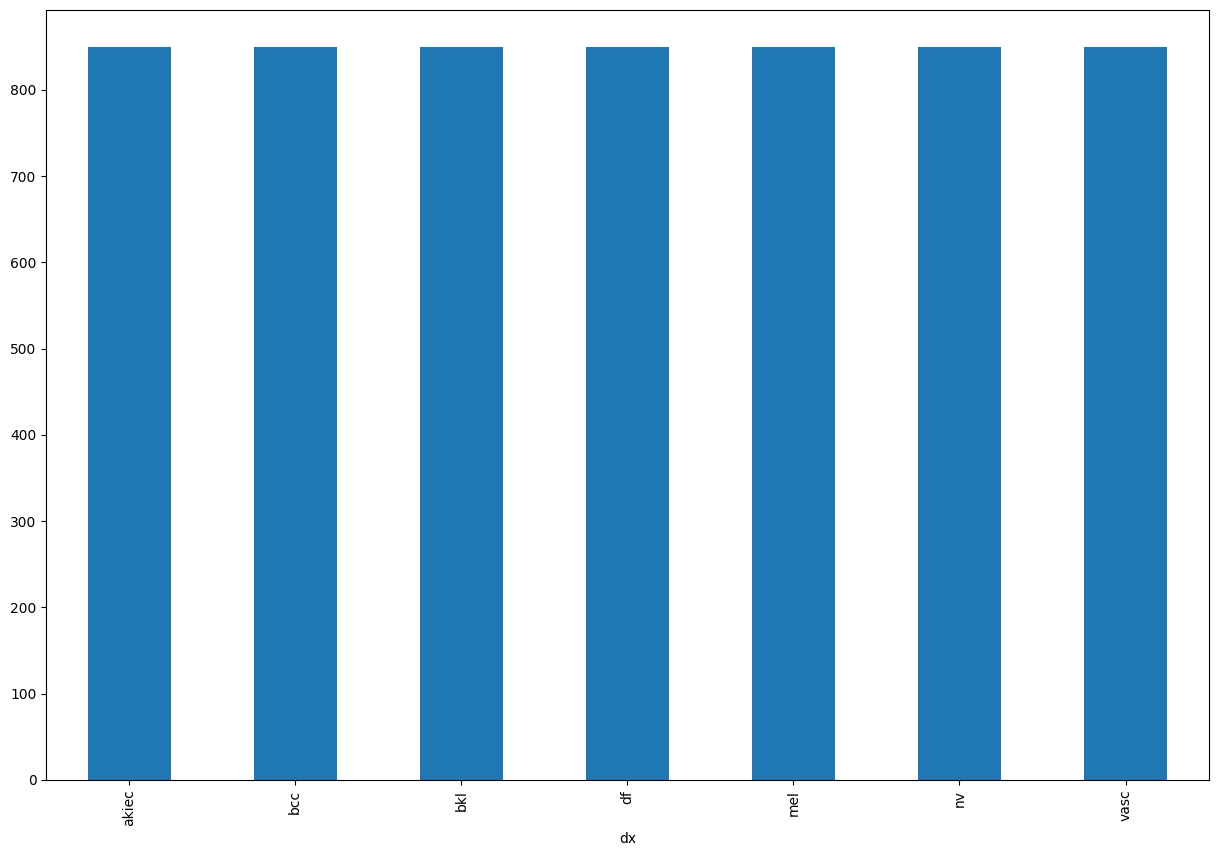

In [5]:
## Balancing the dataset ;
# Data subdivision and resampling with 850 samples per class;
by_class = {}
for i in range(7) :
    var = f"df_{i}_balanced"
    by_class[var] = resample(dataframe[dataframe["label"] == i],
                             replace=True,
                             n_samples=850,
                             random_state=50)
    
# Concatenating into 1 single dataframe;
dataframe_balanced = pd.concat([by_class[f"df_{i}_balanced"] for i in range(7)])

## Printing new balanced Image class count by label ;
print(dataframe_balanced["label"].value_counts())

## Balanced Data visualization ;
figure = plt.figure(figsize=(15,10))
dataframe_balanced["dx"].value_counts().plot(kind="bar")
plt.show()


In [6]:
## X --> Images / Y --> dx labels;
X = np.asarray(dataframe_balanced["image"].tolist())
Y = dataframe_balanced["label"]
# RGB pixel values normalization
X = X/255

# One-hot encoding
Y_tocateg = to_categorical(Y, num_classes=7)

## Data subdivison for training / testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_tocateg, test_size=0.25, random_state=50)

## <--------------------------------------------------------------------------------------------------------------->
## Autokeras to find the best model --> Commented due to a problem with current Tensorflow API version

# Initialize the classifier
# clf = ak.StructuredDataClassifier(max_trials=10)

# # Search for the best model
# clf.fit(X_train, Y_train, validation_data=(X_test, Y_test))

# # Evaluate the best model
# accuracy = clf.evaluate(X_test, Y_test)
# print("Accuracy:", accuracy)
## <---------------------------------------------------------------------------------------------------------------->

# Model layers setup (Sequantial() layer setup n.1)
model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(size[0], size[1], 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
## Model fitting : 70 epochs -> model850 (.80 acc)

batchSize, epochs = 16, 70

FittHis = model.fit(X_train, Y_train, epochs=epochs,
                    batch_size=batchSize,
                    validation_data=(X_test, Y_test),
                    verbose=2)

finalScore = model.evaluate(X_test, Y_test)
print("- ACCURACY : ", finalScore[1])

Epoch 1/70
279/279 - 11s - 40ms/step - acc: 0.2405 - loss: 1.8350 - val_acc: 0.3024 - val_loss: 1.7022
Epoch 2/70
279/279 - 10s - 35ms/step - acc: 0.3599 - loss: 1.5495 - val_acc: 0.3589 - val_loss: 1.5187
Epoch 3/70
279/279 - 11s - 38ms/step - acc: 0.4052 - loss: 1.4396 - val_acc: 0.4382 - val_loss: 1.3979
Epoch 4/70
279/279 - 12s - 44ms/step - acc: 0.4505 - loss: 1.3746 - val_acc: 0.4570 - val_loss: 1.3384
Epoch 5/70
279/279 - 12s - 43ms/step - acc: 0.4664 - loss: 1.3243 - val_acc: 0.4792 - val_loss: 1.3175
Epoch 6/70
279/279 - 12s - 44ms/step - acc: 0.4776 - loss: 1.2886 - val_acc: 0.4798 - val_loss: 1.3340
Epoch 7/70
279/279 - 12s - 43ms/step - acc: 0.5056 - loss: 1.2578 - val_acc: 0.4462 - val_loss: 1.3917
Epoch 8/70
279/279 - 11s - 41ms/step - acc: 0.5249 - loss: 1.2269 - val_acc: 0.5638 - val_loss: 1.1618
Epoch 9/70
279/279 - 11s - 40ms/step - acc: 0.5406 - loss: 1.1827 - val_acc: 0.5450 - val_loss: 1.1752
Epoch 10/70
279/279 - 12s - 42ms/step - acc: 0.5475 - loss: 1.1532 - val_

In [8]:
# Save the model
model.save('model850.h5')

In [12]:

# Load the model
model = load_model('model850.h5')


# Load the input image
img_path = "Data\\HAM10000\\HAM10000_images\\ISIC_0027719.jpg"
img = image.load_img(img_path, target_size=(size[0], size[1])) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image data
img_array /= 255 

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class label
predicted_class = np.argmax(predictions[0])


print("Predicted class:", label_to_class[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Predicted class: akiec
